#  CottonNet: Cotton Disease Prediction using VGG19
### Using Advanced techniques like :
* Transfer Learning
* Data Augmentation

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout

## Fetch / Load the data

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [5]:
!kaggle datasets download -d janmejaybhoi/cotton-disease-dataset

 97% 143M/148M [00:01<00:00, 112MB/s]
100% 148M/148M [00:01<00:00, 117MB/s]


In [6]:
import zipfile
zip_ref = zipfile.ZipFile('/content/cotton-disease-dataset.zip', 'r')
zip_ref.extractall('/content/')
zip_ref.close()

## Data Augmentation

In [7]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

In [8]:
train_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [9]:
train_generator = train_datagen.flow_from_directory(
    '/content/Cotton Disease/train',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    '/content/Cotton Disease/test',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 1951 images belonging to 4 classes.
Found 106 images belonging to 4 classes.


## Build the CNN model

### Load the InceptionResnetV2 model
#### Use Fine Tuning

In [10]:
inception_resnet = InceptionResNetV2(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

219055592/219055592 [==============================] - 1s 0us/step


In [11]:
# Freezing the conv_base in the inception_resnet model
for layer in inception_resnet.layers:
  layer.trainable = False

In [12]:
flatten = Flatten()(inception_resnet.output)
dense1 = Dense(64, activation='relu')(flatten)
dense2 = Dense(32, activation='relu')(dense1)
output = Dense(4, activation='softmax')(dense2)

dnn_model = Model(inputs=inception_resnet.input, outputs=output)

In [13]:
dnn_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [14]:
dnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [15]:
history = dnn_model.fit_generator(train_generator, epochs=10, validation_data=test_generator)

<ipython-input-15-a2c985d7e870>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = dnn_model.fit_generator(train_generator, epochs=10, validation_data=test_generator)


Epoch 1/10
61/61 [==============================] - 70s 774ms/step - loss: 1.0964 - accuracy: 0.6515 - val_loss: 0.4276 - val_accuracy: 0.8491
Epoch 2/10
61/61 [==============================] - 40s 651ms/step - loss: 0.5501 - accuracy: 0.7950 - val_loss: 0.3561 - val_accuracy: 0.8679
Epoch 3/10
61/61 [==============================] - 39s 643ms/step - loss: 0.3868 - accuracy: 0.8524 - val_loss: 0.4036 - val_accuracy: 0.8396
Epoch 4/10
61/61 [==============================] - 39s 643ms/step - loss: 0.3643 - accuracy: 0.8621 - val_loss: 0.2345 - val_accuracy: 0.9340
Epoch 5/10
61/61 [==============================] - 39s 647ms/step - loss: 0.3289 - accuracy: 0.8734 - val_loss: 0.3667 - val_accuracy: 0.9057
Epoch 6/10
61/61 [==============================] - 41s 664ms/step - loss: 0.3997 - accuracy: 0.8580 - val_loss: 0.2673 - val_accuracy: 0.9151
Epoch 7/10
61/61 [==============================] - 40s 652ms/step - loss: 0.3351 - accuracy: 0.8795 - val_loss: 0.2178 - val_accuracy: 0.9340

## Plotting the Accuracy and the loss over each epoch in graph

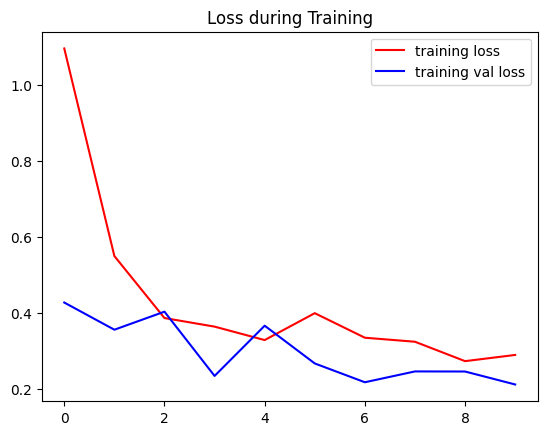

In [16]:
plt.title('Loss during Training')
plt.plot(history.history['loss'], color='red', label='training loss')
plt.plot(history.history['val_loss'], color='blue', label='training val loss')
plt.legend()
plt.show()

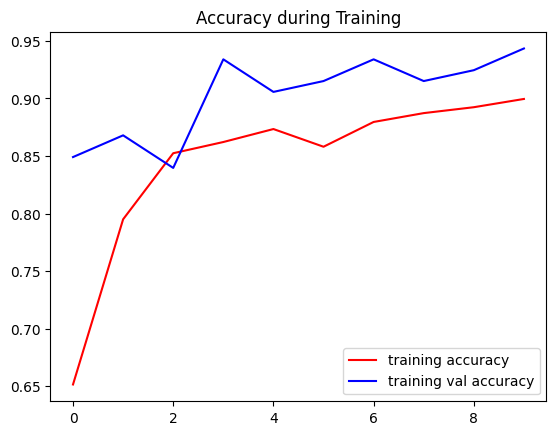

In [17]:
plt.title('Accuracy during Training')
plt.plot(history.history['accuracy'], color='red', label='training accuracy')
plt.plot(history.history['val_accuracy'], color='blue', label='training val accuracy')
plt.legend()
plt.show()

## Save the model

In [19]:
dnn_model.save('inceptionResnetV2.h5')